**Problème 2**

Bloc 1 (Collecte de données) : Importe les données des portefeuilles sectoriels (10 Industries) et des facteurs Fama-French 5 depuis la bibliothèque famafrench.

In [47]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import pandas_datareader.data as web
from pandas_datareader.famafrench import get_available_datasets

industries = web.DataReader(
    "10_Industry_Portfolios_daily",
    "famafrench",
    start="2010-01-01")[0] / 100

ff5 = web.DataReader(
    "F-F_Research_Data_5_Factors_2x3_daily",
    "famafrench",
    start="2010-01-01")[0] / 100

df = industries[["HiTec"]].join(ff5, how="inner")
print("Industries (head):")
print(industries.head(), "\n")

print("Facteurs FF5 (head):")
print(ff5.head())


Industries (head):
             NoDur   Durbl   Manuf   Enrgy   HiTec   Telcm   Shops    Hlth  \
Date                                                                         
2010-01-04  0.0098  0.0235  0.0224  0.0300  0.0159  0.0147  0.0080  0.0131   
2010-01-05  0.0031  0.0257  0.0041  0.0078  0.0000  0.0011 -0.0013 -0.0060   
2010-01-06  0.0022  0.0123  0.0055  0.0094 -0.0069 -0.0103 -0.0003  0.0053   
2010-01-07  0.0004  0.0144  0.0031 -0.0033 -0.0035 -0.0017  0.0063  0.0013   
2010-01-08 -0.0048  0.0055  0.0073  0.0045  0.0076 -0.0015 -0.0001  0.0025   

             Utils   Other  
Date                        
2010-01-04  0.0066  0.0198  
2010-01-05 -0.0084  0.0091  
2010-01-06  0.0054  0.0022  
2010-01-07 -0.0045  0.0168  
2010-01-08 -0.0005  0.0029   

Facteurs FF5 (head):
            Mkt-RF     SMB     HML     RMW     CMA   RF
Date                                                   
2010-01-04  0.0169  0.0079  0.0114 -0.0017  0.0021  0.0
2010-01-05  0.0031 -0.0042  0.0122 -0.00

Bloc 2 (Préparation du DataFrame) : Crée le DataFrame df requis en sélectionnant HiTec comme variable dépendante (première colonne) et en combinant les 5 facteurs comme régresseurs.

In [48]:
# 1. Construire le rendement excédentaire du portefeuille HiTec : (R_i - R_f)
hitec_excess = industries["HiTec"] - ff5["RF"]   # Series

# On en fait un DataFrame et on renomme la colonne pour qu'elle reste 'HiTec'
hitec_excess = hitec_excess.to_frame(name="HiTec")

# 2. Combiner HiTec_excess avec les facteurs Fama-French
df = hitec_excess.join(
    ff5[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]],
    how="inner"
)

# Vérification
print("\nDataFrame final 'df' pour le problème 2a (head):")
print(df.head())
print("\nStructure des colonnes de 'df':")
print(df.columns)



DataFrame final 'df' pour le problème 2a (head):
             HiTec  Mkt-RF     SMB     HML     RMW     CMA
Date                                                      
2010-01-04  0.0159  0.0169  0.0079  0.0114 -0.0017  0.0021
2010-01-05  0.0000  0.0031 -0.0042  0.0122 -0.0018  0.0018
2010-01-06 -0.0069  0.0013 -0.0014  0.0055 -0.0005  0.0020
2010-01-07 -0.0035  0.0040  0.0025  0.0096 -0.0066  0.0022
2010-01-08  0.0076  0.0033  0.0031  0.0002  0.0023 -0.0040

Structure des colonnes de 'df':
Index(['HiTec', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'], dtype='object')


Bloc 3 (Fonction) : Contient la fonction loglik_student_t(df, dof) qui :

Ajuste la régression OLS.

Calcule les résidus standardisés.

Évalue et retourne la log-vraisemblance en utilisant la formule correcte avec le terme de Jacobien.

In [49]:
import numpy as np
import statsmodels.api as sm
from scipy.stats import t

def loglik_student_t(df, dof):
    """
    df : DataFrame avec en 1re colonne la variable dépendante,
         et en colonnes suivantes les régresseurs.
    dof : degrés de liberté (>0) pour la loi t.
    Retourne la log-vraisemblance et le modèle OLS.
    """
    if dof <= 0:
        raise ValueError("dof doit être > 0")
    y = df.iloc[:, 0]
    X = sm.add_constant(df.iloc[:, 1:])
    res = sm.OLS(y, X).fit()
    resid = res.resid
    n, p = X.shape
    sigma = np.sqrt(np.sum(resid**2) / (n - p))  # écart-type des résidus
    r = resid / sigma                            # résidus standardisés
    loglik = t.logpdf(r, df=dof).sum() - n * np.log(sigma)  # Jacobien du redimensionnement
    return loglik, res

# Exemple d'appel :
ll, model = loglik_student_t(df, dof=5)
print("Log-vraisemblance (dof=5):", ll)
print(model.summary().tables[1])  # les coefficients OLS pour info


Log-vraisemblance (dof=5): 16795.7834777431
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.474e-05   5.63e-05      1.506      0.132   -2.56e-05       0.000
Mkt-RF         1.1475      0.005    211.797      0.000       1.137       1.158
SMB           -0.0631      0.010     -6.326      0.000      -0.083      -0.044
HML           -0.3664      0.009    -39.370      0.000      -0.385      -0.348
RMW            0.0893      0.013      6.700      0.000       0.063       0.115
CMA           -0.1711      0.016    -10.414      0.000      -0.203      -0.139


**Problème 2b**

In [50]:
from scipy.stats import chi2

def lr_test_student_t(df, dof):
    """
    Test du rapport de vraisemblance (LR) entre :
      - modèle complet : constante + tous les prédicteurs
      - modèle restreint : constante seule

    df  : DataFrame (1re colonne = Y, autres = X)
    dof : degrés de liberté de la loi t
    """

    # On enlève tout NaN au cas où
    df = df.dropna()

    # 1) Log-vraisemblance du modèle COMPLET
    ll_full, _ = loglik_student_t(df, dof)

    # 2) Log-vraisemblance du modèle RESTREINT (constante seule)
    df_restricted = df.iloc[:, [0]]      # uniquement HiTec comme colonne
    ll_rest, _ = loglik_student_t(df_restricted, dof)

    # 3) Statistique LR
    LR = 2 * (ll_full - ll_rest)

    # 4) p-value sous χ² avec nb_de_restrictions = nb_de_facteurs
    k = df.shape[1] - 1      # nombre de prédicteurs (ici 5)
    p_value = 1 - chi2.cdf(LR, df=k)

    return LR, p_value


# --- Exemple d'appel ---
LR_stat, pval = lr_test_student_t(df, dof=5)
print("LR statistic =", LR_stat)
print("p-value      =", pval)


LR statistic = 10476.072643484207
p-value      = 0.0


**Problème 2c**

EMV (dof) ≈ 15.64


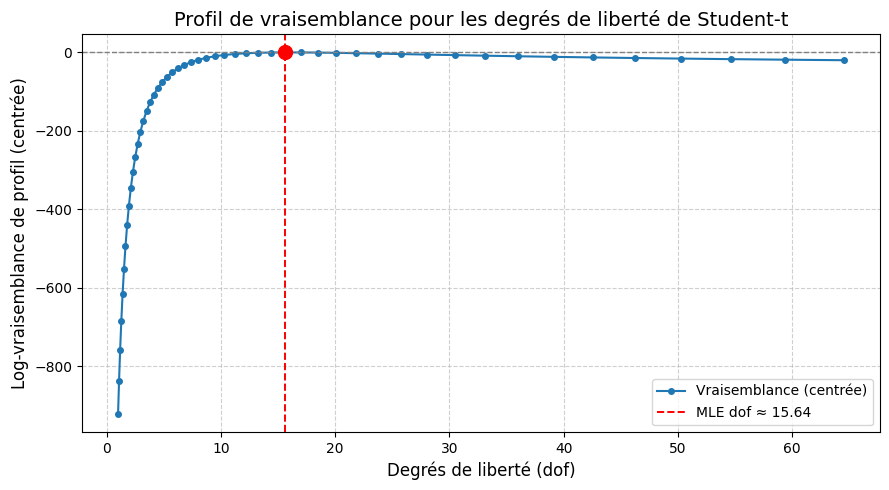

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def profile_likelihood_dof(df):
    df = df.dropna()

    js = np.arange(0, 51)
    dof_grid = np.exp(js / 12)

    loglik_values = []
    for dof in dof_grid:
        ll, _ = loglik_student_t(df, dof=dof)
        loglik_values.append(ll)

    loglik_values = np.array(loglik_values)
    ll_centered = loglik_values - loglik_values.max()

    idx_max = np.argmax(loglik_values)
    dof_mle = dof_grid[idx_max]

    print(f"EMV (dof) ≈ {dof_mle:.2f}")

    plt.figure(figsize=(9, 5))
    plt.plot(dof_grid, ll_centered, marker="o", markersize=4, linewidth=1.5,
             label="Vraisemblance (centrée)")
    plt.axhline(0, color="gray", linestyle="--", linewidth=1)
    plt.scatter(dof_mle, 0, color="red", s=100, zorder=5)
    plt.axvline(dof_mle, color="red", linestyle="--", linewidth=1.4,
                label=f"MLE dof ≈ {dof_mle:.2f}")

    plt.xlabel("Degrés de liberté (dof)", fontsize=12)
    plt.ylabel("Log-vraisemblance de profil (centrée)", fontsize=12)
    plt.title("Profil de vraisemblance pour les degrés de liberté de Student-t", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return dof_grid, loglik_values, dof_mle

# Exemple d'appel
dof_grid, ll_vals, dof_mle = profile_likelihood_dof(df)


Problème 2 d est juste de l'interprétation